# EXAMPLE ON HOW TO GET THE HYBRID BIAS FIELD-LEVEL RESULTS FROM MAP2MAP

Hellooooooo Kate! I hope everything is going wonderful! 

Here I summarise the codes I used to get the field level results with the map2map emulator.

## Some steps prior to computing the fields of the hybrid model

1. First, one needs to have the displacement fields from a Zeldovich simulation and (in case you'd like to compare against a full N-body) from their correspondant N-body simulation, and the linear density field of such simulation (this is for later). Since the map2map emulator was trained on the Quijote simulations, I have prepared one such simulations in the following folder at the atlas cluster (I hope you have access to it, otherwise let me know and I will send you the files):

**N-body displacement: /dipc_storage/mpelle/Yin_data/Fiducial/Quijote/200/**

**ZA displacement: /dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/**

**Linear density: /dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/den_200.npy**

(Note that /dipc_storage/ is called like that only from our node, atlas-248. From the normal atlas log-in nodes it is just called /dipc/).

2. Once you have the ZA displacement field, you will need to install the map2map emulator from Drew's github repository:

https://github.com/dsjamieson/map2map_emu/

3. To get the emulated displacement field, just run the line (changing the paths to wherever you have the files):

```shell
python m2m.py test --test-in-patterns "/dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/dis_200.npy" --test-tgt-patterns "/dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/dis_200.npy" --in-norms "cosmology.dis" --tgt-norms "cosmology.dis" --crop 128 --crop-step 128 --pad 48 --model d2d.StyledVNet --batches 1 --loader-workers 7 --load-state "map2map/weights/d2d_weights.pt" --callback-at "/scratch/mpelle/CodesPostdocDIPC/map2map_emu/" --test-style-pattern "/scratch/mpelle/CodesPostdocDIPC/map2map_emu/style_fyle.txt"
```
I know this is a very confusing line if it is the first time that you see it. Let me know if you have any trouble. The "style_fyle.txt" is a file that the user has to create containing the Om value of the simulation. Since I used the Quijote fiducial cosmology for this example, it is Om=0.3175. It only contains the number, not the "Om=".
The output of this code will be writen in a file called "._out.npy" so you won't be able to see it with a simple ls!!! Once you run it, just move it with the name you prefer, in our case:
```shell
mv ._out.npy emu_disp.npy
```
Now that we have the emulation and the N-body result, we can compute the fields. 

## Computing the emulated fields 

1. We have to load some modules first and set uo a couple of options for the bacco code

In [1]:
import numpy as np
import bacco
import os
import copy
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import deepdish as dd

ngrid = 512 #1024 #512 #256 #128 #256 #1400
nmean=0.01
BoxSize=1000

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : False}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

2. We create a uniform grid of particles as the Initial Conditions of our emulated simulation

In [2]:
grid = bacco.visualization.uniform_grid(npix=ngrid, L=BoxSize, ndim=3, bounds=False)

3. We read the emulated displacement and move the particles

In [3]:
pred_disp = np.load('/scratch/kstoreyf/map2map_emu/emu_disp.npy')

pred_pos = bacco.scaler.add_displacement(None,
                             pred_disp,
                             box=BoxSize,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2023-11-09 16:00:28,630 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Now we have the emulated positions coming from map2map :)

4. We take this emulated simulation and compute the fields that will be used for the hybrid model. To do this we also need the linear density field of the Quijote simulation.

We read the linear density field of the Quijote simulation:

In [4]:
quijote_dir = '/dipc_storage/cosmosims/datashare/Quijote_data'

In [5]:
dens_yin = np.load(f'{quijote_dir}/Fiducial/ZA/200/den_200.npy')

Then initialise the hybrid bias class:

In [6]:
k_nyq = np.pi * ngrid / BoxSize

damping_scale = k_nyq

bmodel = bacco.BiasModel(sim=None, linear_delta=dens_yin[0], ngrid=ngrid, ngrid1=ngrid, 
                         sdm=True, mode="dm", BoxSize=BoxSize,
                         npart_for_fake_sim=ngrid, damping_scale=damping_scale, 
                         bias_model='expansion', deposit_method="cic", 
                         use_displacement_of_nn=False, interlacing=False, 
                         )

2023-11-09 16:00:30,249 bacco.BiasModel : Initialising Bias Model class ...


Ask the bias class to compute the bias fields in Lagrangian coordinates:

In [7]:
bmodel

In [8]:
bias_fields = bmodel.bias_terms_lag()

2023-11-09 16:00:31,576 bacco.BiasModel : Computing delta_to_tidal_field with 12 threads...
2023-11-09 16:00:31,576 bacco.BiasModel : fttw plan
2023-11-09 16:00:31,576 bacco.BiasModel : Computing linear field ...
2023-11-09 16:00:31,577 bacco.BiasModel : Memory used: 6.624067584 Gigabytes
2023-11-09 16:00:31,582 bacco.BiasModel : fttw freqs
2023-11-09 16:00:31,583 bacco.BiasModel : tidk freqs
2023-11-09 16:00:35,649 bacco.BiasModel : ifft
2023-11-09 16:00:59,306 bacco.BiasModel : Computing laplacian ...
2023-11-09 16:00:59,308 bacco.BiasModel : Memory used: 11.462316032 Gigabytes
2023-11-09 16:01:00,319 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2023-11-09 16:01:00,320 bacco.BiasModel : Memory used: 11.999596544 Gigabytes
2023-11-09 16:01:00,473 bacco.BiasModel : Computing delta squared ...
2023-11-09 16:01:00,474 bacco.BiasModel : Memory used: 12.536213504 Gigabytes
2023-11-09 16:01:01,207 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2

Weight the emulated positions by the lagrangian fields: 

In [9]:
bias_terms_eul_pred=[]
for ii in range(0,len(bias_fields)):
    bias_terms_pred = bacco.statistics.compute_mesh(ngrid=ngrid, box=BoxSize, pos=pred_pos, 
                              mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                              interlacing=False)
    bias_terms_eul_pred.append(bias_terms_pred)
bias_terms_eul_pred = np.array(bias_terms_eul_pred)

2023-11-09 16:01:11,232 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-11-09 16:01:11,233 bacco.statistics : starting deposit 1
2023-11-09 16:01:12,805 bacco.statistics :  mesh done in 1.57 s
2023-11-09 16:01:13,058 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-11-09 16:01:13,059 bacco.statistics : starting deposit 1
2023-11-09 16:01:14,612 bacco.statistics :  mesh done in 1.55 s
2023-11-09 16:01:14,857 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-11-09 16:01:14,858 bacco.statistics : starting deposit 1
2023-11-09 16:01:16,409 bacco.statistics :  mesh done in 1.55 s
2023-11-09 16:01:16,648 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-11-09 16:01:16,649 bacco.statistics : starting deposit 1
2023-11-09 16:01:18,192 bacco.statistics :  mesh done in 1.54 s
2023-11-09 16:01:18,435 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2

5. We repeat the same procedure but with the Quijote displacements to get the N-body results:

In [10]:
sim_disp = np.load(f'{quijote_dir}/Fiducial/Quijote/200/dis_200.npy')

sim_pos = bacco.scaler.add_displacement(None,
                             sim_disp,
                             box=BoxSize,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2023-11-09 16:01:22,098 bacco.scaler : Adding displacement field with a vel-factor=0.000000


In [11]:
bias_terms_eul_sim=[]
for ii in range(0,len(bias_fields)):
    bias_terms_sim = bacco.statistics.compute_mesh(ngrid=ngrid, box=BoxSize, pos=sim_pos, 
                              mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                              interlacing=False)
    bias_terms_eul_sim.append(bias_terms_sim)
bias_terms_eul_sim = np.array(bias_terms_eul_sim)

2023-11-09 16:01:23,825 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-11-09 16:01:23,826 bacco.statistics : starting deposit 1
2023-11-09 16:01:25,437 bacco.statistics :  mesh done in 1.61 s
2023-11-09 16:01:25,675 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-11-09 16:01:25,677 bacco.statistics : starting deposit 1
2023-11-09 16:01:27,261 bacco.statistics :  mesh done in 1.59 s
2023-11-09 16:01:27,507 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-11-09 16:01:27,508 bacco.statistics : starting deposit 1
2023-11-09 16:01:29,037 bacco.statistics :  mesh done in 1.53 s
2023-11-09 16:01:29,275 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-11-09 16:01:29,276 bacco.statistics : starting deposit 1
2023-11-09 16:01:30,847 bacco.statistics :  mesh done in 1.57 s
2023-11-09 16:01:31,086 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2

Let's plot a couple of them to check that everything went as expected:

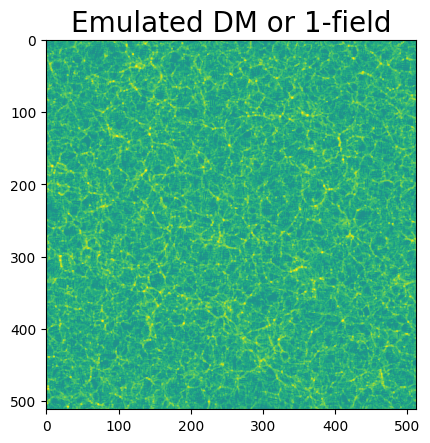

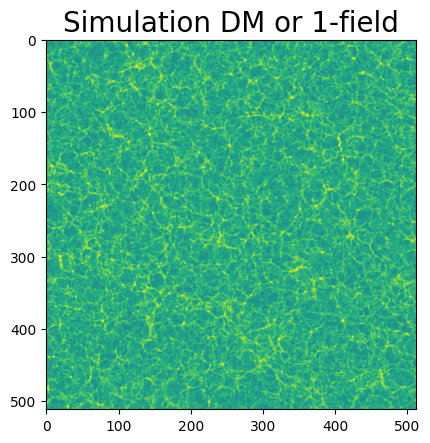

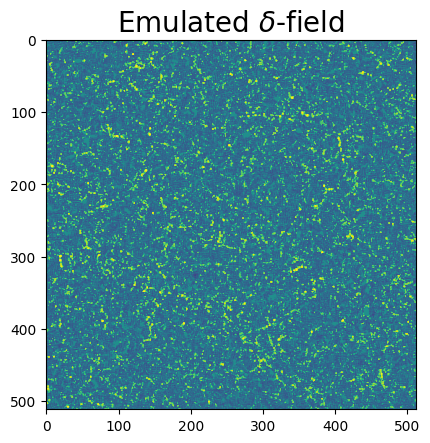

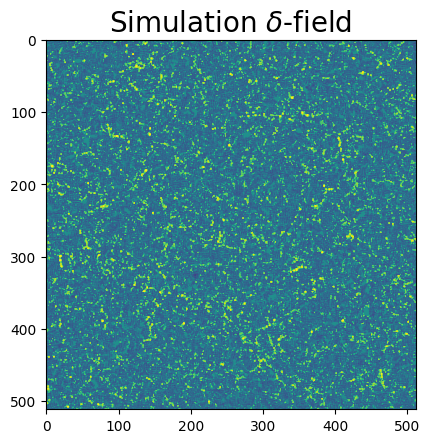

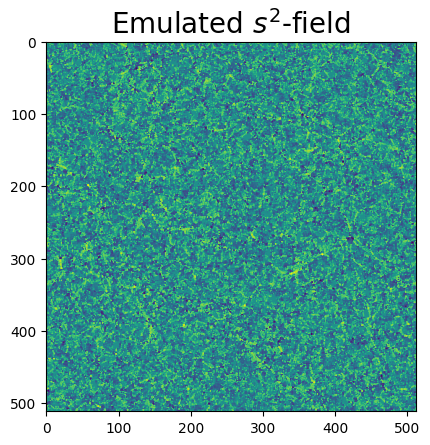

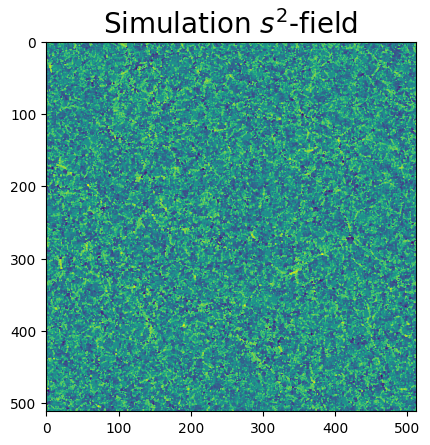

In [12]:
# Set normalisation
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-100.0, vmax=100.0)

#Plot 1-term
plt.imshow(bias_terms_eul_pred[0][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated DM or 1-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[0][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation DM or 1-field', size=20)
plt.show()

#Plot delta-term
plt.imshow(bias_terms_eul_pred[1][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated $\delta$-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[1][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation $\delta$-field', size=20)
plt.show()

#Plot tidal-term
plt.imshow(bias_terms_eul_pred[3][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated $s^2$-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[3][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation $s^2$-field', size=20)
plt.show()

#### Everything looks good so far! I am as surprised as you are :)

## Computing the emulated spectra

Let's see what the results are from a more quantitative point of view. Let's compute their power spectra and compare N-body versus emulated results.

1. We need to define the arguments for the power spectrum computation within bacco (but you can use any power spectrum calculator of course).

In [13]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

##################

# These are the important arguments of the P(k)
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':False,
                  'kmin':0.01,
                  'kmax':1,
                  'nbins':50,
                  'correct_grid':True,
                  'log_binning':True,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'compute_power2d':False}


#This is what I was talking about some corrections one can make to the P(k) computation
#Not very important though, ask Raul if you want to know more
lt_k = np.logspace(np.log10(np.pi / BoxSize), np.log10(2 * np.pi / BoxSize * ngrid), num=90)
pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo_Quijote, expfactor=cosmo_Quijote.expfactor, wavemode=lt_k)

#Normalise the grid before P(k) computation
#one can normalise later too, I chose to do it here
norm=ngrid**3.
bias_terms_eul_norm_pred = bias_terms_eul_pred/norm


2023-11-09 16:01:35,966 bacco.cosmo :    initialization took 0.000 secs
2023-11-09 16:01:36,357 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.266 secs
2023-11-09 16:01:36,363 bacco.cosmo :    created Pk(z=0) tab from k 0.0006710999999999998 to 100000.0 h/Mpc


2. And compute the power spectrum of the 15 auto and cross terms

In [14]:

#Compute a dummy variable with the 15 combinations of 5 distinct objects
import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul_pred.shape[0]),r=2)))

#Compute the P(k) of the 15 terms
power_all_terms_pred = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True

    power_term_pred = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm_pred[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm_pred[prod[ii,1]],
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=True,
                                                    deconvolve_grid2=True,
                                                    **args_power)
    power_all_terms_pred.append(power_term_pred)


2023-11-09 16:01:39,745 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:01:39,748 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.002 secs
2023-11-09 16:01:42,240 bacco.statistics :  ...done in 2.49 s
2023-11-09 16:01:42,243 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:01:44,666 bacco.statistics :  ...done in 2.42 s
2023-11-09 16:01:44,671 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (13

2023-11-09 16:01:47,101 bacco.statistics :  ...done in 2.43 s
2023-11-09 16:01:47,104 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:01:49,600 bacco.statistics :  ...done in 2.5 s
2023-11-09 16:01:49,603 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:01:52,075 bacco.statistics :  ...done in 2.47 s
2023-11-09 16:01:52,076 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:01:54,517 bacco.statistics :  ...done in 2.44 s
2023-11-09 16:01:54,522 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:01:56,946 bacco.statistics :  ...done in 2.42 s
2023-11-09 16:01:56,950 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:01:59,491 bacco.statistics :  ...done in 2.54 s
2023-11-09 16:01:59,492 bacco.statistics : Computing the power spectrum with ngrid=5

er : done Fourier loop in 0.000708 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -6.89433e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.474894 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.459224 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000277 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -6.81316e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: F

2023-11-09 16:02:04,492 bacco.statistics :  ...done in 2.48 s
2023-11-09 16:02:04,496 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:06,897 bacco.statistics :  ...done in 2.4 s
2023-11-09 16:02:06,898 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:09,310 bacco.statistics :  ...done in 2.41 s
2023-11-09 16:02:09,311 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:11,698 bacco.statistics :  ...done in 2.39 s
2023-11-09 16:02:11,699 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:14,106 bacco.statistics :  ...done in 2.41 s
2023-11-09 16:02:14,109 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:16,549 bacco.statistics :  ...done in 2.44 s


3. We repeat the same for the Quijote N-body results

In [15]:
#Normalise the grid before P(k) computation
norm=ngrid**3.
bias_terms_eul_norm_sim = bias_terms_eul_sim/norm

#Compute the P(k) of the 15 terms
power_all_terms_sim = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True

    power_term_sim = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm_sim[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm_sim[prod[ii,1]],
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=True,
                                                    deconvolve_grid2=True,
                                                    **args_power)
    power_all_terms_sim.append(power_term_sim)
    

2023-11-09 16:02:17,550 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:19,999 bacco.statistics :  ...done in 2.45 s
2023-11-09 16:02:20,002 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:22,431 bacco.statistics :  ...done in 2.43 s
2023-11-09 16:02:22,433 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.56306e-05 (grid1) -6.89433e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.443492 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.377917 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000284 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.56306e-05 (grid1) -6.81316e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.458575 s

2023-11-09 16:02:24,845 bacco.statistics :  ...done in 2.41 s
2023-11-09 16:02:24,846 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:27,168 bacco.statistics :  ...done in 2.32 s
2023-11-09 16:02:27,169 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:29,571 bacco.statistics :  ...done in 2.4 s
2023-11-09 16:02:29,573 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:31,915 bacco.statistics :  ...done in 2.34 s
2023-11-09 16:02:31,918 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:34,324 bacco.statistics :  ...done in 2.41 s
2023-11-09 16:02:34,325 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:36,767 bacco.statistics :  ...done in 2.44 s
2023-11-09 16:02:36,768 bacco.statistics : Computing the power spectrum with ngrid=5

wer : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -1.563e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.490326 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.406133 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000323 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -6.89434e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.457452 sec
bacco.power : Counting modes
bacco.power : done counting modes 

2023-11-09 16:02:41,461 bacco.statistics :  ...done in 2.35 s
2023-11-09 16:02:41,462 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:43,818 bacco.statistics :  ...done in 2.36 s
2023-11-09 16:02:43,820 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:46,181 bacco.statistics :  ...done in 2.36 s
2023-11-09 16:02:46,182 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:48,537 bacco.statistics :  ...done in 2.36 s
2023-11-09 16:02:48,538 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:50,898 bacco.statistics :  ...done in 2.36 s
2023-11-09 16:02:50,901 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-11-09 16:02:53,321 bacco.statistics :  ...done in 2.42 s


4. And we plot them to see how accurate the map2map emulator is in the 2-point statistics:

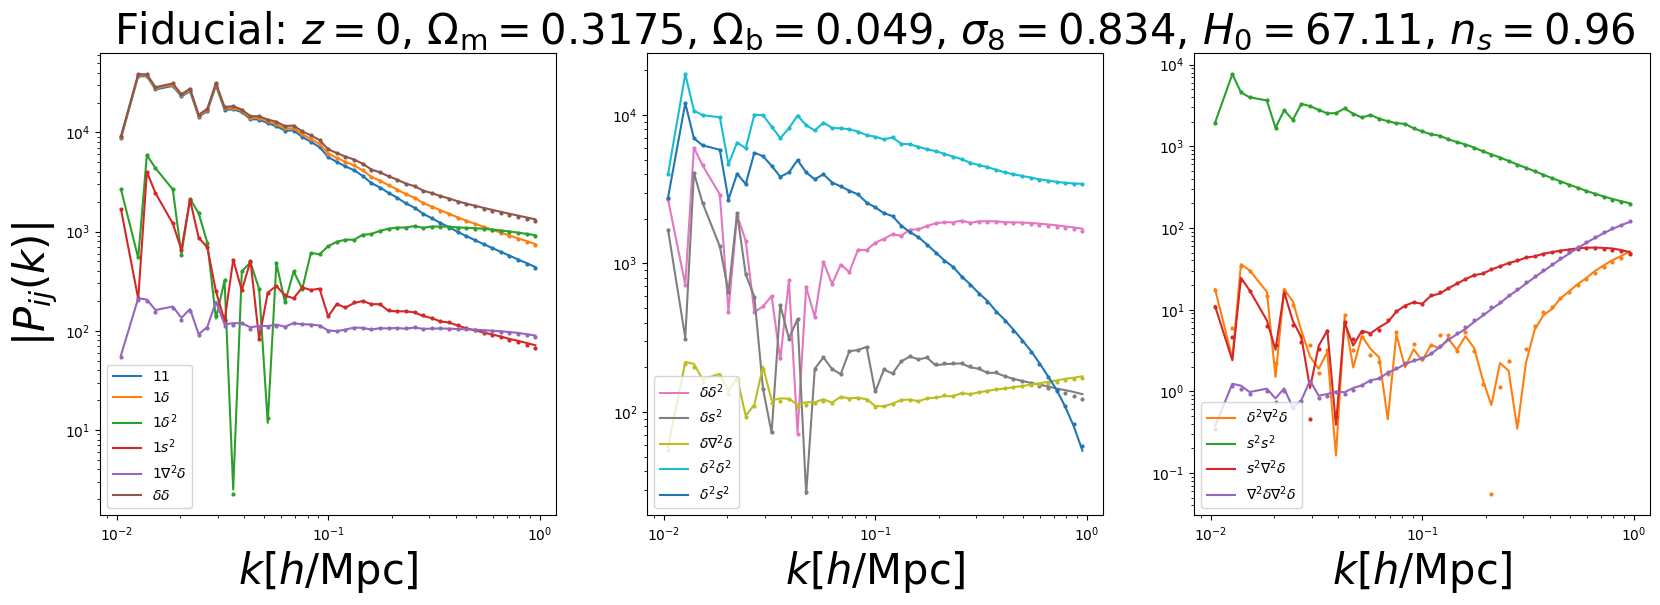

In [16]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

labels = ['$1 1$',
 '$1 \\delta$',
 '$1 \\delta^2$',
 '$1 s^2$',
 '$ 1 \\nabla^2\\delta$',
 '$\\delta \\delta$',
 '$\\delta \\delta^2$',
 '$\\delta s^2$',
 '$\\delta \\nabla^2\\delta$',
 '$\\delta^2 \\delta^2$',
 '$\\delta^2 s^2$',
 '$\\delta^2 \\nabla^2\\delta$',
 '$s^2 s^2$',
 '$s^2 \\nabla^2\\delta$',
 '$\\nabla^2\\delta \\nabla^2\\delta$']

indices = range(0,15)

contf=0
for ii in indices:
    mask = np.abs(power_all_terms_sim[ii]['pk'])>0
    ax[contf].loglog(power_all_terms_pred[ii]['k'][mask], np.abs(power_all_terms_pred[ii]['pk'][mask]),
                       color='C'+str(ii), label=labels[ii])
    ax[contf].loglog(power_all_terms_pred[ii]['k'][mask], np.abs(power_all_terms_sim[ii]['pk'][mask]),
                       'o', markersize=2, color='C'+str(ii))

    ax[contf].legend(loc='lower left', frameon=True, fancybox=True)
    ax[contf].set_xlabel(r'$k[h/$Mpc]', size=30)
    if ii%5==0 and ii>0:
        contf+=1   

ax[0].set_ylabel(r'$ |P_{ij}(k)| $', size=30)
#ax[0].set_ylim(10.,1e5)

ax[1].set_title(r'Fiducial: $z=0$, $\Omega_{\rm m}=0.3175$, $\Omega_{\rm b}=0.049$, $\sigma_8=0.834$, $H_0=67.11$, $n_s=0.96$',
                 fontsize=30)
plt.show()


### And that's it. Thanks for reading until here!

### Marcos :)